* Please do not remove this note and add notes below for any comments for this codes

* #### Created by 경제모형실 서범석 at 2023.8월
PRISM-now computes the central ensemble forecast using dynamic quantile selection and estimate ensemble distribution by approximating the base model distribution to a parametric skewed t-distribution.

* #### Modified by 경제모형실 서범석 at 2023.12월
상명대 이동진 교수님의 조언에 따라 아웃라이어를 제거하던 과정을 배제하였음

* #### Distibuted to 경제모형실 조형배 at 2024.6월
경제모형실 조형배 조사역에게 공유

* #### Modified by 경제모형실 서범석 at 2024.7월
GDP SA 변동성 확대에 대응하여 모수 Lambda 조정 반영

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

In [1015]:
TODAY = '241219'

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

## 0. <font color=blue> Import APIs

In [1016]:
!pip install enlighten

In [1017]:
import enlighten

In [1018]:
import os, copy
from os import walk
from os import path
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

In [1019]:
import matplotlib.pyplot as plt
import seaborn as sns

In [1020]:
import matplotlib.cbook as cbook

In [1021]:
import statsmodels.api as sm
import statsmodels as sm_

In [1022]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings

In [1023]:
from pathlib import Path

In [1024]:
from scipy import optimize
from scipy.optimize import minimize

### 0-1.Set environment

In [1025]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [1026]:
def rmse(y_pred,y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))
def mae(y_pred,y_true):
    return np.mean(np.abs(y_pred-y_true))

In [1027]:
if not path.isdir('./fig'):
  os.mkdir('./fig')

#### 그래프 및 한글세팅

In [1028]:
!sudo apt-get update -qq
!sudo apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [1029]:
%matplotlib inline

from matplotlib.font_manager import fontManager, FontProperties
from matplotlib import rcParams

In [1030]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# fontpath = './NanumBarunGothic.ttf'
fontManager.addfont(fontpath)
fontprop = FontProperties(fname=fontpath, size=10)
fontname = fontprop.get_name()
print(fontname)

rcParams['font.family'] = fontname
rcParams['axes.unicode_minus'] =False
# sns.set(font=fontname)

# sns.set_context("poster", font_scale=1.2)

NanumBarunGothic


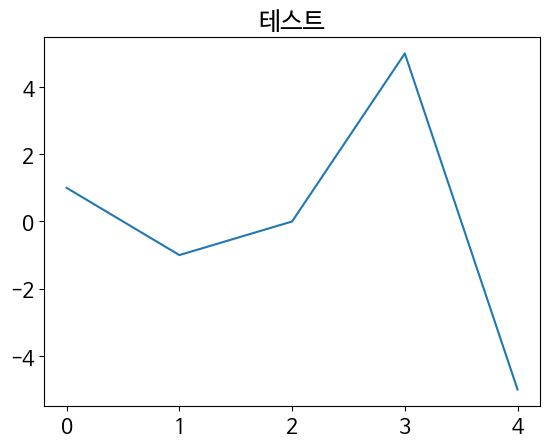

In [1031]:
plt.title('테스트')
pd.Series([1, -1, 0, 5, -5]).plot()
None

In [1032]:
# from matplotlib import font_manager as fm
# font_dirs = ['D:/8.work/font/']
# font_files = fm.findSystemFonts(fontpaths=font_dirs)

# for font_file in font_files:
#     fm.fontManager.addfont(font_file)

# # set font
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

In [1033]:
# from matplotlib import font_manager as fm
# font_dirs = ['D:/8.work/font/']
# font_files = fm.findSystemFonts(fontpaths=font_dirs)

# for font_file in font_files:
#     fm.fontManager.addfont(font_file)

# # set font
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

## 1. <font color=blue> Analysis

In [1034]:
os.getcwd()

'/content'

### 1-0. Base model predicted values

In [1035]:
# Old results
SAM = {'2.1': [-0.41,-0.07,0.24],
       '2.8': [0.20,0.31,0.45],
       '3.3': [0.79,0.64,0.77,0.71,0.12],
       '3.13':[0.39,0.25,0.48,0.51,0.27],
       '3.30':[0.51,0.36,0.57,0.84,0.79,0.03],
       '4.11':[0.49,0.36,0.55,0.90,0.79,0.04],
       '4.28':[0.96,0.98,0.91,0.44,0.67],
       '5.8': [0.84,0.87,0.79,0.83,0.77,0.72],
       '5.11':[0.72,0.74,0.70,0.75,0.77,0.65],
       '5.30':[0.67,0.70,0.62,0.98,1.07,0.81],
       '6.9': [0.73,0.74,0.66,0.99,1.07,0.75],
       '6.12':[0.78,0.79,0.70,0.99,1.07,0.75], # DFM 1.21 (6월 수출 및 5월 모니터링 반영시)
       '6.30':[0.91,0.91,0.75,1.09,0.79],
       '7.7': [0.79,0.79,0.70,1.09,0.79],
       '6.30 (2/4)':[0.91,0.91,0.75,1.70,1.09,0.79,0.88,
              1.02,0.38,0.74,0.42,0.31,0.65],
       '6.30 (3/4)':[0.60,0.57,0.80,0.61,0.66,0.98,0.98,
              0.85,0.56,0.72,0.59,0.80,0.86],
       '7.7 (2/4)':[0.79,0.79,0.70,1.60,1.09,0.79,0.93,
              0.88,0.23,0.70,0.25,0.37,0.85],
       '7.7 (3/4)':[0.49,0.47,0.69,0.24,0.66,0.96,0.86,
              0.80,0.46,0.71,0.65,0.81,0.83],
       '7.27 (2/4)':[0.78,0.78,0.69,1.16,1.40,0.79,0.93,
              0.91,0.35,0.77,0.62,0.51,1.12],

       '7.27 (3/4)':[0.26,0.26,0.44,0.24,1.24,0.75,1.02,
              0.81,0.10,0.50,0.25,0.63,0.87],
       '7.27 (4/4)':[0.32,0.26,0.45,0.49,0.24,0.94,0.84,
              0.83,0.36,0.73,0.73,0.67,1.12],

       '8.4 (3/4)':[0.36,0.36,0.51,0.37,1.41,0.84,0.75,
              0.74,-0.46,0.25,0.33,0.60,0.72],
       '8.4 (4/4)':[0.33,0.27,0.55,0.33,0.70,1.06,1.22,
              0.79,0.43,0.78,0.78,0.61,1.08],

       '8.30 (3/4)':[0.29,0.27,0.39,0.29,1.01,0.62,0.71,
              0.45,-0.66,0.08,0.24,0.41,0.52],
       '8.30 (4/4)':[0.38,0.33,0.41,0.09,0.32,0.66,0.85,
              0.65,0.53,0.85,0.79,0.68,0.92],

       '9.15 (3/4)':[0.31,0.29,0.40,0.31,1.10,0.59,0.78,
              0.45,-0.68,0.12,0.13,0.36,0.42],
       '9.15 (4/4)':[0.37,0.32,0.37,0.16,0.78,0.42,0.56,
              0.65,0.55,0.87,0.77,0.73,0.99],
       '10.4 (3/4)':[0.62,0.58,0.61,0.30,1.50,0.63,0.84,
              0.71,-0.21,0.46,0.25,0.38,0.48],
       '10.4 (4/4)':[0.65,0.60,0.69,0.10,-1.80,0.90,0.87,
              0.81,0.73,0.98,0.68,0.76,1.40],
       '10.12 (3/4)':[0.64,0.61,0.62,0.30,1.50,0.61,0.81,
              0.70,-0.19,0.52,0.41,0.38,0.65],
       '10.12 (4/4)':[0.66,0.62,0.71,0.04,-1.80,0.31,0.73,
              0.80,1.08,1.30,0.82,0.75,1.37]        }


BM = {'2.1': ['min','avg','max'],
      '2.8': ['min','avg','max'],
      '3.3': ['BEM1','BEM2','Copula','DFM','LBVAR'],
      '3.13':['BEM1','BEM2','Copula','DFM','LBVAR'],
      '3.30':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '4.11':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '4.28':['BEM1','BEM2','Copula','DFM','TFM'],
      '5.8':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '5.11':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '5.30':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.9':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.12':['BEM1','BEM2','Copula','DFM','LBVAR','TFM'],
      '6.30':['L-DFM1','L-DFM2','Copula','LBVAR','TFM'],
      '7.7':['L-DFM1','L-DFM2','Copula','LBVAR','TFM'],
  '6.30 (2/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '6.30 (3/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.7 (2/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.7 (3/4)':['L-DFM1','L-DFM2','Copula','K-DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (2/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '7.27 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.4 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.4 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.30 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '8.30 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '9.15 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '9.15 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.4 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.4 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.12 (3/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB'],
  '10.12 (4/4)':['BEM1','BEM2','BEM3','DFM','LBVAR','TFM','T-M',
             'VAR','LQR','OptimARIMA','SVR-KNN','RF-DVS','S-XGB']        }

Target = {'2.1': '2023Q1',
      '2.8': '2023Q1',
      '3.3': '2023Q1',
      '3.13':'2023Q1',
      '3.30':'2023Q1',
      '4.11':'2023Q1',
      '4.28':'2023Q2',
      '5.8': '2023Q2',
      '5.11':'2023Q2',
      '5.30':'2023Q2',
      '6.9': '2023Q2',
      '6.12':'2023Q2',
      '6.30':'2023Q2',
    '6.30 (2/4)':'2023Q2',
    '6.30 (3/4)':'2023Q3',
    '7.7 (2/4)':'2023Q2',
    '7.7 (3/4)':'2023Q3',
    '7.27 (2/4)':'2023Q2',
    '7.27 (3/4)':'2023Q3',
    '7.27 (4/4)':'2023Q4',
    '8.4 (3/4)':'2023Q3',
    '8.4 (4/4)':'2023Q4',
    '8.30 (3/4)':'2023Q3',
    '8.30 (4/4)':'2023Q4',
    '9.15 (3/4)':'2023Q3',
    '9.15 (4/4)':'2023Q4',
    '10.4 (3/4)':'2023Q3',
    '10.4 (4/4)':'2023Q4',
    '10.12 (3/4)':'2023Q3',
    '10.12 (4/4)':'2023Q4',
         }



In [1036]:
model_names0 = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
                'VAR', 'LQR', 'OptimARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1037]:
new_key = '10.31 (4/4)'
SAM[new_key] = [0.74,0.71,0.78,0.27,0.50,0.83,0.70,
               0.95,1.30,1.39,0.84,0.86,0.70]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [1038]:
new_key = '10.31 (1/4)'
SAM[new_key] = [0.31,0.26,0.73,0.25,0.40,0.71,0.72,
               0.83,0.32,0.60,0.32,0.67,0.62]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [1039]:
new_key = '11.16 (4/4)'
SAM[new_key] = [0.89,0.86,0.82,0.27,0.35,0.75,0.71,
               1.5,0.79,1.42,0.87,0.72,0.70]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [1040]:
new_key = '11.16 (1/4)'
SAM[new_key] = [0.35,0.31,0.66,0.28,0.55,0.66,0.58,
               1.15,0.64,0.70,0.09,0.66,0.62]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [1041]:
new_key = '11.30 (4/4)'
SAM[new_key] = [0.77,0.73,0.74,0.25,-0.1,0.65,0.77,
                1.13,0.71,1.00,0.67,0.70,0.74]
BM[new_key] = model_names0
Target[new_key] = '2023Q4'

In [1042]:
new_key = '11.30 (1/4)'
SAM[new_key] = [0.39,0.35,0.67,0.24,0.80,0.81,0.52,
                0.95,0.40,0.65,0.21,0.64,0.63]
BM[new_key] = model_names0
Target[new_key] = '2024Q1'

In [1043]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1044]:
new_key = '12.19 (4/4)'
SAM[new_key] = [0.81,0.77,0.73,0.23,np.nan,0.64,0.73,
                0.8,0.37,0.69,0.65,0.49,0.70]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [1045]:
new_key = '12.19 (1/4)'
SAM[new_key] = [0.50,0.46,0.70,0.21,np.nan,0.76,0.77,
                0.77,0.15,0.45,0.20,0.66,0.95]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1046]:
new_key = '12.27 (4/4)'
SAM[new_key] = [0.84,0.80,0.75,0.23,np.nan,0.67,0.69,
                0.80,0.43,0.74,0.72,0.51,0.70]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [1047]:
new_key = '12.27 (1/4)'
SAM[new_key] = [0.55,0.51,0.70,0.22,np.nan,0.80,0.79,
                0.76,0.24,0.52,0.12,0.65,0.97]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1048]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1049]:
new_key = '1.4 (4/4)'
SAM[new_key] = [0.82,0.78,0.74,0.22,np.nan,0.67,0.68,
                0.65,0.80,0.94,0.77,0.61,0.61]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [1050]:
new_key = '1.4 (1/4)'
SAM[new_key] = [0.52,0.48,0.71,0.19,np.nan,0.80,0.74,
                0.79,0.90,0.84,0.18,0.64,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1051]:
new_key = '1.9 (4/4)'
SAM[new_key] = [0.81,0.77,0.73,0.22,np.nan,0.69,0.69,
                0.65,0.80,0.94,0.77,0.61,0.61]
BM[new_key] = model_names
Target[new_key] = '2023Q4'

In [1052]:
new_key = '1.9 (1/4)'
SAM[new_key] = [0.57,0.54,0.74,0.19,np.nan,0.84,0.48,
                0.79,0.89,0.85,0.22,0.64,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1053]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1054]:
new_key = '1.30 (1/4)'
SAM[new_key] = [0.16,0.13,0.31,0.63,np.nan,0.94,0.66,
                0.67,0.86,0.80,0.71,0.50,0.92]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1055]:
new_key = '1.30 (2/4)'
SAM[new_key] = [0.32,0.27,0.36,0.30,np.nan,0.80,0.82,
                0.79,0.39,0.67,0.38,0.65,1.18]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1056]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1057]:
new_key = '2.13 (1/4)'
SAM[new_key] = [0.53,0.50,0.57,0.39,np.nan,0.87,0.45,
                0.32,1.16,0.94,0.80,0.54,0.92]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1058]:
new_key = '2.13 (2/4)'
SAM[new_key] = [0.36,0.31,0.53,-0.23,np.nan,0.67,0.57,
                0.48,0.32,0.62,0.30,0.66,0.84]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1059]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1060]:
new_key = '3.4 (1/4)'
SAM[new_key] = [0.69,0.69,0.68,0.42,np.nan,0.91,0.31,
                0.41,0.62,0.74,0.80,0.54,0.92]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1061]:
new_key = '3.4 (2/4)'
SAM[new_key] = [0.44,0.39,0.65,-0.04,np.nan,0.66,0.49,
                0.48,np.nan,0.61,0.30,0.66,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1062]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1063]:
new_key = '3.15 (1/4)'
SAM[new_key] = [0.59,0.56,0.57,0.67,np.nan,0.98,0.56,
                0.49,0.62,0.82,0.54,0.71,0.88]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1064]:
new_key = '3.15 (2/4)'
SAM[new_key] = [0.36,0.31,0.52,1.12,np.nan,0.60,0.52,
                0.50,np.nan,0.35,0.47,0.56,0.88]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1065]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1066]:
new_key = '3.28 (1/4)'
SAM[new_key] = [0.70,0.70,0.66,0.69,np.nan,1.02,0.62,
                0.62,0.83,0.95,0.548173178,1.03129966,1.056465108]
BM[new_key] = model_names
Target[new_key] = '2024Q1'

In [1067]:
new_key = '3.28 (2/4)'
SAM[new_key] = [0.29,0.25,0.52,0.92,np.nan,0.51,0.51,
                0.53,np.nan,0.40,0.44,0.46,0.78]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1068]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1069]:
new_key = '4.29 (2/4)'
SAM[new_key] = [0.55,0.35,0.72,0.46,np.nan,0.61,0.87,
                0.27,-0.40,0.31,0.65,0.57,0.44]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1070]:
new_key = '4.29 (3/4)'
SAM[new_key] = [0.43,0.38,0.71,0.30,np.nan,0.83,0.73,
                0.35,-0.06,0.42,0.82,0.66,0.77]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1071]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1072]:
new_key = '5.10 (2/4)'
SAM[new_key] = [0.55,0.35,0.65,0.46,np.nan,0.68,0.85,
                0.40,-0.00,0.48,0.56,0.54,0.44]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1073]:
new_key = '5.10 (3/4)'
SAM[new_key] = [0.40,0.35,0.55,0.27,np.nan,0.82,0.86,
                0.31,0.07,0.47,0.75,0.80,0.79]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1074]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1075]:
new_key = '5.30 (2/4)'
SAM[new_key] = [0.59,0.40,0.67,0.49,np.nan,0.70,0.92,
                0.55,0.19,0.37,0.44,0.52,0.51]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1076]:
new_key = '5.30 (3/4)'
SAM[new_key] = [0.46,0.41,0.61,0.36,np.nan,0.78,0.83,
                0.43,0.08,0.51,0.77,0.71,0.76]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1077]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1078]:
new_key = '6.10 (2/4)'
SAM[new_key] = [0.43,0.23,0.58,0.52,np.nan,0.58,np.nan,
                -0.46,-0.47,0.23,0.31,0.78,0.39]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1079]:
new_key = '6.10 (3/4)'
SAM[new_key] = [0.43,0.38,0.57,0.45,np.nan,0.70,np.nan,
                0.44,-0.14,0.19,0.54,0.60,1.06]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1080]:
model_names = ['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

In [1081]:
new_key = '6.28 (2/4)'
SAM[new_key] = [0.40,0.20,0.56,0.53,np.nan,0.52,np.nan,
                0.16,-0.08,0.28,0.29,0.80,0.68]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1082]:
new_key = '6.28 (3/4)'
SAM[new_key] = [0.39,0.34,0.53,0.53,np.nan,1.09,np.nan,
                0.28,-0.13,-0.24,0.63,0.61,0.86]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1083]:
new_key = '7.3 (2/4)'
SAM[new_key] = [0.53,0.33,0.64,0.53,np.nan,0.52,np.nan,
                0.16,0.04,0.30,0.136473645,0.414679416,0.386812992]
BM[new_key] = model_names
Target[new_key] = '2024Q2'

In [1084]:
new_key = '7.3 (3/4)'
SAM[new_key] = [0.56,0.51,0.70,0.53,np.nan,1.09,np.nan,
                0.22,0.07,-0.17,0.61,0.62,0.86]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1085]:
new_key = '7.30 (3/4)'
SAM[new_key] = [0.52,0.64,0.58,np.nan,np.nan,1.11,np.nan,
                0.31,0.15,0.70,0.80,0.49,0.73]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1086]:
new_key = '7.30 (4/4)'
SAM[new_key] = [0.44,0.30,0.28,np.nan,np.nan,0.58,np.nan,
                0.45,0.00,0.61,0.63,0.44,0.79]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1087]:
new_key = '8.8 (3/4)'
SAM[new_key] = [0.39,0.50,0.52,np.nan,np.nan,1.08,np.nan,
                0.35,0.13,0.60,0.55,0.23,0.78]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1088]:
new_key = '8.8 (4/4)'
SAM[new_key] = [0.56,0.41,0.42,np.nan,np.nan,0.56,np.nan,
                0.94,0.08,0.73,0.63,0.43,0.77]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1089]:
new_key = '9.2 (3/4)'
SAM[new_key] = [0.48,0.46,0.65,np.nan,np.nan,1.1,np.nan,
                0.47,0.27,0.62,0.49,0.23,0.94]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1090]:
new_key = '9.2 (4/4)'
SAM[new_key] = [0.42,0.27,0.43,np.nan,np.nan,0.58,np.nan,
                0.35,0.08,0.70,0.79,0.46,0.77]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1091]:
new_key = '9.12 (3/4)'
SAM[new_key] = [0.61,0.59,0.53,np.nan,np.nan,1.04,np.nan,
                0.47,0.15,0.83,0.77,0.57,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1092]:
new_key = '9.12 (4/4)'
SAM[new_key] = [0.49,0.34,0.45,np.nan,np.nan,0.58,np.nan,
                0.35,0.15,0.80,0.96,0.60,0.70]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1093]:
new_key = '9.30 (3/4)'
SAM[new_key] = [0.49,0.47,0.37,np.nan,np.nan,1.04,np.nan,
                0.47,-0.30,0.49,0.39,0.65,0.63]
BM[new_key] = model_names
Target[new_key] = '2024Q3'

In [1094]:
new_key = '9.30 (4/4)'
SAM[new_key] = [0.46,0.31,0.38,np.nan,np.nan,0.57,np.nan,
                0.35,0.03,0.68,0.76,0.61,0.66]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1095]:
# new_key = '10.10 (3/4)'
# SAM[new_key] = [0.74,0.73,0.63,np.nan,np.nan,1.03,np.nan,
#                 0.47,0.22,0.88,0.52,0.69,0.63]
# BM[new_key] = model_names
# Target[new_key] = '2024Q3'

In [1096]:
# new_key = '10.10 (4/4)'
# SAM[new_key] = [0.75,0.61,0.65,np.nan,np.nan,0.58,np.nan,
#                 0.35,0.86,1.55,1.27,1.02,0.66]
# BM[new_key] = model_names
# Target[new_key] = '2024Q4'

In [1097]:
new_key = '10.29 (4/4)'
SAM[new_key] = [0.56,0.44,0.49,0.29,np.nan,0.66,np.nan,
                0.35,0.29,0.70,0.82,0.40,0.53]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1098]:
new_key = '10.29 (25.1/4)'
SAM[new_key] = [0.40,0.33,0.47,0.67,np.nan,0.81,np.nan,
                0.49,0.06,0.50,0.42,0.53,0.76]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1099]:
new_key = '24.10.31 (4/4)'
# SAM[new_key] = [0.50,0.38,0.44,1.30,np.nan,0.61,np.nan,
SAM[new_key] = [0.50,0.38,0.44,np.nan,np.nan,0.61,np.nan,
                0.21,0.19,0.60,0.63,0.52,0.53]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1100]:
new_key = '24.10.31 (25.1/4)'
# SAM[new_key] = [0.40,0.32,0.42,2.73,np.nan,0.81,np.nan,
SAM[new_key] = [0.40,0.32,0.42,np.nan,np.nan,0.81,np.nan,
                0.55,0.06,0.49,0.64,0.66,0.76]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1101]:
new_key = '24.11.12 (4/4)'
SAM[new_key] = [0.51,0.39,0.49,np.nan,np.nan,0.62,np.nan,
                0.21,0.26,0.66,0.40,0.51,0.53]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1102]:
new_key = '24.11.12 (25.1/4)'
SAM[new_key] = [0.40,0.32,0.44,np.nan,np.nan,0.81,np.nan,
                0.55,0.06,0.50,0.25,0.65,0.76]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1103]:
new_key = '24.11.29 (4/4)'
SAM[new_key] = [0.60,0.48,0.47,np.nan,np.nan,0.58,np.nan,
                0.21,0.14,0.51,0.64,0.52,0.54]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1104]:
new_key = '24.11.29 (25.1/4)'
SAM[new_key] = [0.43,0.35,0.48,np.nan,np.nan,0.71,np.nan,
                0.55,0.08,0.52,0.55,0.52,0.82]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1105]:
new_key = '24.12.3 (4/4)'
SAM[new_key] = [0.46,0.44,0.46,np.nan,np.nan,0.58,np.nan,
                0.21,0.08,0.43,0.37,0.52,0.54]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1106]:
new_key = '24.12.3 (25.1/4)'
SAM[new_key] = [0.43,0.36,0.46,np.nan,np.nan,0.71,np.nan,
                0.55,0.06,0.48,0.37,0.52,0.82]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1107]:
['BEM1', 'BEM2', 'BEM3', 'DFM', 'LBVAR', 'TFM', 'T-M',
               'VAR', 'LQR', 'ARIMA', 'SVR-KNN', 'RF-DVS', 'S-XGB']

['BEM1',
 'BEM2',
 'BEM3',
 'DFM',
 'LBVAR',
 'TFM',
 'T-M',
 'VAR',
 'LQR',
 'ARIMA',
 'SVR-KNN',
 'RF-DVS',
 'S-XGB']

In [1108]:
new_key = '24.12.19 (4/4)'
SAM[new_key] = [0.42,0.22,0.41,np.nan,np.nan,0.58,np.nan,
                0.21,0.14,0.30,0.44,0.44,0.49]
BM[new_key] = model_names
Target[new_key] = '2024Q4'

In [1109]:
new_key = '24.12.19 (25.1/4)'
SAM[new_key] = [0.15,0.01,0.24,np.nan,np.nan,0.68,np.nan,
                0.55,0.06,0.44,0.59,0.37,0.57]
BM[new_key] = model_names
Target[new_key] = '2025Q1'

In [1110]:
bp = np.empty((max([len(SAM[x]) for x in SAM]),len(SAM)))
bp[:] = np.nan

for i,x in enumerate(SAM):
    l = len(SAM[x])
    bp[:l,i] = SAM[x]

bp = pd.DataFrame(bp)
bp.columns = SAM.keys()

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

In [1111]:
TODAY

'241219'

#### <font color=red> Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | Today | </font>

### 1-1. Set modules

In [1112]:
"""Main module."""

import numpy as np
from scipy import stats
from scipy.special import beta


class SST:
    # Init Parameters
    def __init__(self, mu, sigma, nu, tau):
        """
        Creates an Instance of the Skewed Student T Distribution.
        In this parameterization the expectation equals mu and standard
        deviation equals sigma.
        :param mu: mu parameter
        :type mu: scalar or array_like
        :param sigma: sigma parameter
        :type sigma: scalar or array_like
        :param nu: nu parameter
        :type nu: scalar or array_like
        :param tau: tau parameter
        :type tau: scalar or array_like
        """
        self.mu = np.asarray(mu).astype(float)
        self.sigma = np.asarray(sigma).astype(float)
        self.nu = np.asarray(nu).astype(float)
        self.tau = np.asarray(tau).astype(float)
        self.c = 2 * self.nu * ((1 + self.nu ** 2) *
                                beta(0.5, self.tau / 2) *
                                self.tau ** 0.5) ** -1
        self.m = ((2 * self.tau ** 0.5) * (self.nu - self.nu ** -1)) / (
                (self.tau - 1) * beta(0.5, 0.5 * self.tau))
        self.s2 = ((self.tau / (self.tau - 2)) * (
                self.nu ** 2 + self.nu ** -2 - 1) - self.m ** 2)
        self.mu_0 = self.mu - (self.sigma * self.m / np.sqrt(self.s2))
        self.sigma_0 = self.sigma / np.sqrt(self.s2)

    # Density Function
    def d(self, y):
        """Density Function
        :param y: distribution values
        :type y: scalar or array_like
        :return: density at the specified y values
        :rtype: array
        """
        mu_0 = self.mu_0
        sigma_0 = self.sigma_0
        c = self.c
        nu = self.nu
        tau = self.tau
        z = (y - mu_0) / sigma_0
        p = np.where(y < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p

    def q(self, p):
        """Quantile Function / Inverse CDF / Percent Point Function
        :param p: probabilities
        :type p: scalar or array_like
        :return: Quantile values corresponding to the specified probabilities.
        :rtype: array
        """
        p = np.asarray(p).astype(float)
        mu_0 = self.mu_0
        sigma_0 = self.sigma_0
        nu = self.nu
        tau = self.tau
        # Calculate quantile
        quantile = np.where(p <= (1 + nu ** 2) ** -1,
                            mu_0 + (sigma_0 / nu) * stats.t.ppf(
                                (p * (1 + nu ** 2)) * 0.5, tau),
                            mu_0 + sigma_0 * nu * stats.t.ppf(
                                (p * (1 + nu ** 2) - 1 + nu ** 2) / (
                                        2 * nu ** 2), tau)
                            )
        return quantile

    # Cumulative Distribution Function
    def p(self, q):
        """Distribution Function
        :param q: value
        :type q: scalar or array_like
        :return: The probability that the SST distributed variable will take
        a value less than or equal to q.
        :rtype: array
        """
        nu = self.nu
        mu_0 = self.mu_0
        tau = self.tau
        sigma_0 = self.sigma_0
        # Calculate CDF
        prob = np.where(q < mu_0,
                        (2 / (1 + nu ** 2)) * stats.t.cdf(
                            x=(nu * (q - mu_0) / sigma_0), df=tau),
                        (1 / (1 + nu ** 2)) * (
                            1 + 2 * nu ** 2 * (
                                stats.t.cdf(x=(q - mu_0) / (sigma_0 * nu),
                                            df=tau) - 0.5))
                        )
        return prob

    # Draw Random Numbers using Inversion Sampling
    def r(self, n=1):
        """Draws Random Numbers which Follow the SST Distribution
        :param n: sample size
        :type n: int or tuple of return shape, optional
        :return: random sample drawn from the SST distribution
        :rtype: array
        .. note::
           n is ignored if the distribution parameters are provided as
           arrays. In that case, a sample with the shape of the provided arrays
           will be drawn. i.e. n = 1.
        """
        return self.q(p=np.random.random(size=n))

In [1113]:
def sstq(params):

    nu = params[0]
    tau = params[1]

    sstq_ = SST(mu_0, sigma_0, nu, tau)

    quantiles = [q10,q25,q75,q90]
    percents = [0.1,0.25,0.75,0.9]

    obj = sum([(quantiles[i] - sstq_.q(percents[i]))**2 for i in range(4)])

    return obj

In [1114]:
len_obs = len(SAM)

In [1115]:
MX = pd.DataFrame([[np.nanmean(SAM[list(SAM.keys())[i]]), np.nanstd(SAM[list(SAM.keys())[i]])] for i in range(len_obs)])
MX.columns = ['mean','std']
MX.index = list(SAM.keys())

In [1116]:
p_list = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
QX = pd.DataFrame([[np.nanpercentile(SAM[list(SAM.keys())[i]],p) for p in p_list] for i in range(len_obs)])
QX.columns = ['p'+str(p) for p in p_list]
QX.index = list(SAM.keys())

In [1117]:
#QX

### 1-2. Outliers <- depricated

In [1118]:
XXR = copy.deepcopy(SAM)
for t in SAM.keys():
    q25 = QX.loc[t,'p25']
    q75 = QX.loc[t,'p75']
    IQR = q75 - q25

    for i,_ in enumerate(XXR[t]):
        if XXR[t][i] < (q25-1.5*IQR):
            XXR[t][i] = np.nan
        if XXR[t][i] > (q75+1.5*IQR):
            XXR[t][i] = np.nan

In [1119]:
for i in list(XXR.keys())[37:]:
    XXR[i] = copy.deepcopy(SAM)[i]

In [1120]:
for t in list(XXR.keys())[-7:]:
    print(BM[t][4])
    XXR[t][4] = np.nan

LBVAR
LBVAR
LBVAR
LBVAR
LBVAR
LBVAR
LBVAR


In [1121]:
XXR_BM = {}
for k in XXR.keys():
    XXR_BM[k] = list(zip(BM[k],XXR[k]))

In [1122]:
MXR = pd.DataFrame([[np.nanmean(XXR[list(XXR.keys())[i]]), np.nanstd(XXR[list(XXR.keys())[i]]), np.nanmedian(XXR[list(XXR.keys())[i]])] for i in range(len_obs)])
MXR.columns = ['mean','std','med']
MXR.index = list(XXR.keys())

In [1123]:
MXR_ = pd.DataFrame([[np.nanmedian(XXR[list(XXR.keys())[i]]), np.nanstd(XXR[list(XXR.keys())[i]]), np.nanmedian(XXR[list(XXR.keys())[i]])] for i in range(len_obs)])
MXR_.columns = ['median','std', 'med']
MXR_.index = list(XXR.keys())

In [1124]:
p_list = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,99]
QXR = pd.DataFrame([[np.percentile(pd.DataFrame(XXR[i]).dropna(),p) for p in p_list] for i in XXR.keys()])
QXR.columns = ['p'+str(p) for p in p_list]
QXR.index = XXR.keys()

In [1125]:
# QXR

### 1-3. Estimate skewed t-dist

In [1126]:
bounds = [(0.01,10), (2.0,10)]

In [1127]:
params_hat = pd.DataFrame(columns=['nu','tau'])

# DAT = QXR
#=====================
DAT = QXR
#=====================

results = dict()
for t in tqdm(DAT.index):

    mu_0 = MXR.loc[t,'mean']
    sigma_0 = MXR.loc[t,'std']
    q10 = DAT.loc[t,'p10']
    q25 = DAT.loc[t,'p25']
    q75 = DAT.loc[t,'p75']
    q90 = DAT.loc[t,'p90']

    res = minimize(sstq, x0=(1,5), bounds=bounds)#, method = 'BFGS')
    results[t] = res

    optim = res.x[:2]
    # params_hat = params_hat.append(pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t]))
    params_hat = pd.concat([params_hat, pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t])])


  0%|          | 0/89 [00:00<?, ?it/s]

In [1128]:
params_hat_prev = params_hat

In [1129]:
def xnu(xnu, tau):
    # mu_0=0;
    # sigma_0=10;
    nu=xnu[1] #1.2;
    # tau=2.1;
    # q_0 = 0.5
    tt = SST(mu_0,sigma_0,nu,tau)
    x=xnu[0]
    return tt.d(x)

def xtau(xtau, nu):
    # mu_0=0;
    # sigma_0=10;
    # nu=1.2;
    tau=xtau[1]#2.1;
    # q_0 = 0.5
    tt = SST(mu_0,sigma_0,nu,tau)
    x=xtau[0]
    return tt.d(x)

In [1130]:
def plotDat(t, x_list = np.arange(-0.2,1.2,0.01), params_hat=params_hat):
    try:
        mu_0 = qval_.loc[t,'yhat-']
    except:
        mu_0 = MXR.loc[t,'mean']
    sigma_0 = MXR.loc[t,'std']
    q10 = QX.loc[t,'p10']
    q25 = QX.loc[t,'p25']
    q75 = QX.loc[t,'p75']
    q90 = QX.loc[t,'p90']
    nu_0 = params_hat.loc[t,'nu']
    tau_0 = params_hat.loc[t,'tau']

#     if tau_0==2.0:
#         tau_0 += 0.0000001

    return np.array([SST(mu_0,sigma_0,nu_0,tau_0).d(x) for x in x_list])

In [1131]:
# x_list = np.arange(0.2,1.4,0.01)
# plt.plot(x_list, plotDat('7.27 (2/4)',x_list))

### 1-4. Dynamic Quantile Selection (DQS) Algorithm

In [1132]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

#### <font color=red> Add current and base quarter index

In [1133]:
cp_list = [['7.7 (3/4)','7.7 (2/4)'],
           ['7.27 (3/4)','7.27 (2/4)'],
           ['8.4 (3/4)','7.27 (2/4)'],
           ['8.30 (3/4)','7.27 (2/4)'],
           ['9.15 (3/4)','7.27 (2/4)'],
           ['10.4 (3/4)','7.27 (2/4)'],
           ['10.12 (3/4)','7.27 (2/4)'],
           ['7.27 (4/4)','7.27 (3/4)'],
           ['8.4 (4/4)','8.4 (3/4)'],
           ['8.30 (4/4)','8.30 (3/4)'],
           ['9.15 (4/4)','9.15 (3/4)'],
           ['10.4 (4/4)','10.4 (3/4)'],
           ['10.12 (4/4)','10.12 (3/4)'],
           ['10.31 (4/4)','10.12 (3/4)'],
           ['11.16 (4/4)','10.12 (3/4)'],
           ['11.30 (4/4)','10.12 (3/4)'],
           ['12.19 (4/4)','10.12 (3/4)'],
           ['12.27 (4/4)','10.12 (3/4)'],
           ['1.4 (4/4)','10.12 (3/4)'],
           ['1.9 (4/4)','10.12 (3/4)'],
           ['10.31 (1/4)','10.31 (4/4)'],
           ['11.16 (1/4)','11.16 (4/4)'],
           ['11.30 (1/4)','11.30 (4/4)'],
           ['12.19 (1/4)','12.19 (4/4)'],
           ['12.27 (1/4)','12.27 (4/4)'],
           ['1.4 (1/4)','1.4 (4/4)'],
           ['1.9 (1/4)','1.9 (4/4)'],
           ['1.30 (1/4)','1.9 (4/4)'],
           ['2.13 (1/4)','1.9 (4/4)'],
           ['3.4 (1/4)','1.9 (4/4)'],
           ['3.15 (1/4)','1.9 (4/4)'],
           ['3.28 (1/4)','1.9 (4/4)'],
           ['1.30 (2/4)','1.30 (1/4)'],
           ['2.13 (2/4)','2.13 (1/4)'],
           ['3.4 (2/4)','3.4 (1/4)'],
           ['3.15 (2/4)','3.15 (1/4)'],
           ['3.28 (2/4)','3.28 (1/4)'],
           ['4.29 (2/4)','3.28 (1/4)'],
           ['5.10 (2/4)','3.28 (1/4)'],
           ['5.30 (2/4)','3.28 (1/4)'],
           ['6.10 (2/4)','3.28 (1/4)'],
           ['6.28 (2/4)','3.28 (1/4)'],
           ['7.3 (2/4)','3.28 (1/4)'],
           ['4.29 (3/4)','4.29 (2/4)'],
           ['5.10 (3/4)','5.10 (2/4)'],
           ['5.30 (3/4)','5.30 (2/4)'],
           ['6.10 (3/4)','6.10 (2/4)'],
           ['6.28 (3/4)','6.28 (2/4)'],
           ['7.3 (3/4)','7.3 (2/4)'],
           ['7.30 (3/4)','7.3 (2/4)'],
           ['8.8 (3/4)','7.3 (2/4)'],
           ['9.2 (3/4)','7.3 (2/4)'],
           ['9.12 (3/4)','7.3 (2/4)'],
           ['9.30 (3/4)','7.3 (2/4)'],
           # ['10.10 (3/4)','7.3 (2/4)'],
           ['7.30 (4/4)','7.30 (3/4)'],
           ['8.8 (4/4)','8.8 (3/4)'],
           ['9.2 (4/4)','9.2 (3/4)'],
           ['9.12 (4/4)','9.12 (3/4)'],
           ['9.30 (4/4)','9.30 (3/4)'],
           ['10.29 (4/4)','9.30 (3/4)'],
           ['24.10.31 (4/4)','9.30 (3/4)'],
           ['24.11.12 (4/4)','9.30 (3/4)'],
           ['24.11.29 (4/4)','9.30 (3/4)'],
           ['24.12.3 (4/4)','9.30 (3/4)'],
           ['24.12.19 (4/4)','9.30 (3/4)'],
           ['10.29 (25.1/4)','10.29 (4/4)'],
           ['24.10.31 (25.1/4)','24.10.31 (4/4)'],
           ['24.11.12 (25.1/4)','24.10.31 (4/4)'],
           ['24.12.3 (25.1/4)','24.12.3 (4/4)'],
           ['24.12.19 (25.1/4)','24.12.19 (4/4)'],
           ]

In [1134]:
#====================================================

In [1135]:
# MXR

In [1136]:
lev_list = pd.DataFrame(cp_list, columns=['c_','p_'])
lev_list['lev'] = 200

In [1137]:
locs = np.where([x in ['3.4 (1/4)','3.15 (1/4)','3.28 (1/4)',
                       '5.30 (2/4)', '6.10 (2/4)', '6.28 (2/4)', '7.3 (2/4)',
                       # '24.12.19 (4/4)',
                       ] for x in lev_list['c_']])[0]

In [1138]:
lev_list.loc[locs,'lev'] = 200*700

In [1139]:
locs = np.where([x in ['24.12.19 (4/4)',
                       ] for x in lev_list['c_']])[0]
lev_list.loc[locs,'lev'] = 200*50

In [1140]:
# locs0 = np.where([x in ['5.30 (2/4)'] for x in lev_list['c_']])[0]

In [1141]:
# lev_list.loc[locs0,'lev'] = 200*700

In [1142]:
lev_list

,c_,p_,lev
0,7.7 (3/4),7.7 (2/4),200
1,7.27 (3/4),7.27 (2/4),200
2,8.4 (3/4),7.27 (2/4),200
3,8.30 (3/4),7.27 (2/4),200
4,9.15 (3/4),7.27 (2/4),200
5,10.4 (3/4),7.27 (2/4),200
6,10.12 (3/4),7.27 (2/4),200
7,7.27 (4/4),7.27 (3/4),200
8,8.4 (4/4),8.4 (3/4),200
9,8.30 (4/4),8.30 (3/4),200


In [1143]:
#====================================================

### 1-5. Compute DQS

In [1144]:
MXR

,mean,std,med
2.1,-0.080000,0.265456,-0.070000
2.8,0.320000,0.102307,0.310000
3.3,0.727500,0.058470,0.740000
3.13,0.380000,0.105830,0.390000
3.30,0.516667,0.271886,0.540000
4.11,0.521667,0.281390,0.520000
4.28,0.792000,0.207981,0.910000
5.8,0.803333,0.049554,0.810000
5.11,0.721667,0.038909,0.730000
5.30,0.808333,0.165471,0.755000


In [1145]:
qval_ = pd.DataFrame(index = ['7.7 (2/4)', '6.30 (3/4)'])
qval_['q'] = [50,50]
qval_['yhat'] = MXR['mean'][['7.7 (2/4)','6.30 (3/4)']]

qval_['q-'] = [50,50]
qval_['yhat-'] = MXR['mean'][['7.7 (2/4)','6.30 (3/4)']]

for c_,p_,lev_ in lev_list.to_numpy():
    MXRdiff = MXR.loc[c_] - MXR.loc[p_]

    std = MXR.loc[c_]['std']
    lev = 200*(std**2)
    disp = MXRdiff['std']
    diff = MXRdiff['mean']

    qval_.loc[c_,'q'] = 50+clamp(np.sign(diff)*max(disp,0)*lev,-50,50)
    qval_.loc[c_,'yhat'] = np.percentile([x for x in XXR[c_] if ~np.isnan(x)],qval_.loc[c_,'q'])

    mean = MXR['mean'][c_]
    med = MXR['med'][c_]
    lev = lev_


    qval_.loc[c_,'q-'] = 50+clamp(np.sign(diff)*max(disp,0)*(std**2)*np.exp(np.sign(diff)*(mean-med))*lev,-50,50)
    #qval_.loc[t,'q-'] = 50+clamp(np.sign(diff)*max(disp,0)*np.exp(np.sign(diff)*(mean-med)*(std**2))*lev,-50,50)
    if c_ == '24.12.19 (4/4)':
      qval_.loc[c_,'q-'] = 50+clamp(np.sign(diff)*max(0.05,0)*(std**2)*np.exp(np.sign(diff)*(mean-med))*lev,-50,50)
    qval_.loc[c_,'yhat-'] = np.percentile([x for x in XXR[c_] if ~np.isnan(x)],qval_.loc[c_,'q-'])

    qval_.loc[c_,'mean'] = mean
    qval_.loc[c_,'med'] = med
    qval_.loc[c_,'lev'] = lev_

In [1146]:
qval_

,q,yhat,q-,yhat-,mean,med,lev
7.7 (2/4),50.000000,0.835556,50.000000,0.835556,NaN,NaN,NaN
6.30 (3/4),50.000000,0.736923,50.000000,0.736923,NaN,NaN,NaN
7.7 (3/4),49.414230,0.687891,49.398708,0.687835,0.663846,0.690000,200.0
7.27 (3/4),47.365264,0.481030,47.535818,0.482258,0.566923,0.500000,200.0
8.4 (3/4),50.000000,0.510000,50.000000,0.510000,0.530000,0.510000,200.0
8.30 (3/4),50.000000,0.390000,50.000000,0.390000,0.388182,0.390000,200.0
9.15 (3/4),50.000000,0.335000,50.000000,0.335000,0.338000,0.335000,200.0
10.4 (3/4),50.000000,0.580000,50.000000,0.580000,0.532727,0.580000,200.0
10.12 (3/4),50.000000,0.610000,50.000000,0.610000,0.568182,0.610000,200.0
7.27 (4/4),50.000000,0.670000,50.000000,0.670000,0.613846,0.670000,200.0


In [1147]:
# qval_.to_excel('result.xlsx')

### 1-6. ReEstimate skewed t-dist

In [1148]:
import warnings
warnings.filterwarnings('ignore')

In [1149]:
bounds = [(0.01,10), (2.0,10)]

In [1150]:
params_hat = pd.DataFrame(columns=['nu','tau'])

# DAT = QXR
#=====================
DAT = QXR
#=====================

results = dict()
for t in tqdm(DAT.index):

    try:
        mu_0 = qval_.loc[t,'yhat-']
    except:
        mu_0 = MXR.loc[t,'mean']
    sigma_0 = MXR.loc[t,'std']
    q10 = DAT.loc[t,'p10']
    q25 = DAT.loc[t,'p25']
    q75 = DAT.loc[t,'p75']
    q90 = DAT.loc[t,'p90']

    res = minimize(sstq, x0=(1,5), bounds=bounds)#, method = 'BFGS')
    results[t] = res

    optim = res.x[:2]
    # params_hat = params_hat.append(pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t]))
    params_hat = pd.concat([params_hat, pd.DataFrame({'nu':optim[0], 'tau':optim[1]},index=[t])])


  0%|          | 0/89 [00:00<?, ?it/s]

## 2.  <font color=blue> Plotting

### 2-1.  Dist plot

#### <font color=red> Change current and base quarter index

In [1151]:
QX

,p1,p5,p10,p15,p20,p25,p30,p35,p40,p45,p50,p55,p60,p65,p70,p75,p80,p85,p90,p95,p99
2.1,-0.403200,-0.376000,-0.342000,-0.308000,-0.274,-0.2400,-0.206,-0.1720,-0.138,-0.104000,-0.070000,-0.039000,-0.008000,0.02300,0.054,0.0850,0.116,0.147000,0.17800,0.209000,0.233800
2.8,0.202200,0.211000,0.222000,0.233000,0.244,0.2550,0.266,0.2770,0.288,0.299000,0.310000,0.324000,0.338000,0.35200,0.366,0.3800,0.394,0.408000,0.42200,0.436000,0.447200
3.3,0.140800,0.224000,0.328000,0.432000,0.536,0.6400,0.654,0.6680,0.682,0.696000,0.710000,0.722000,0.734000,0.74600,0.758,0.7700,0.774,0.778000,0.78200,0.786000,0.789200
3.13,0.250800,0.254000,0.258000,0.262000,0.266,0.2700,0.294,0.3180,0.342,0.366000,0.390000,0.408000,0.426000,0.44400,0.462,0.4800,0.486,0.492000,0.49800,0.504000,0.508800
3.30,0.046500,0.112500,0.195000,0.277500,0.360,0.3975,0.435,0.4725,0.510,0.525000,0.540000,0.555000,0.570000,0.62500,0.680,0.7350,0.790,0.802500,0.81500,0.827500,0.837500
4.11,0.056000,0.120000,0.200000,0.280000,0.360,0.3925,0.425,0.4575,0.490,0.505000,0.520000,0.535000,0.550000,0.61000,0.670,0.7300,0.790,0.817500,0.84500,0.872500,0.894500
4.28,0.449200,0.486000,0.532000,0.578000,0.624,0.6700,0.718,0.7660,0.814,0.862000,0.910000,0.920000,0.930000,0.94000,0.950,0.9600,0.964,0.968000,0.97200,0.976000,0.979200
5.8,0.722500,0.732500,0.745000,0.757500,0.770,0.7750,0.780,0.7850,0.790,0.800000,0.810000,0.820000,0.830000,0.83250,0.835,0.8375,0.840,0.847500,0.85500,0.862500,0.868500
5.11,0.652500,0.662500,0.675000,0.687500,0.700,0.7050,0.710,0.7150,0.720,0.725000,0.730000,0.735000,0.740000,0.74250,0.745,0.7475,0.750,0.755000,0.76000,0.765000,0.769000
5.30,0.622500,0.632500,0.645000,0.657500,0.670,0.6775,0.685,0.6925,0.700,0.727500,0.755000,0.782500,0.810000,0.85250,0.895,0.9375,0.980,1.002500,1.02500,1.047500,1.065500


In [1152]:
c = '24.12.19 (4/4)'
p = '24.12.3 (4/4)'

points_cur = pd.Series(XXR[c])
points_cur.name = c
points_pre = pd.Series(XXR[p])
points_pre.name = p

In [1153]:
def sstq2(params, sigma_0, q5, dqs, q95):

    mu = params[0]
    nu = params[1]
    tau = params[2]

    sstq_ = SST(mu, sigma_0, nu, tau)

    quantiles = [q5, dqs, q95]
    percents = [0.05,0.50,0.95]

    obj = sum([(quantiles[i] - sstq_.q(percents[i]))**2 for i in range(len(percents))])

    return obj

In [1154]:
def plotDat(t, x_list = np.arange(-0.2,1.2,0.01), params_hat=params_hat):


    sigma_0 = MXR.loc[t,'std']
    try:
        dqs = qval_.loc[t,'yhat-']
    except:
        dqs = MXR.loc[t,'med']

    q5 = QX.loc[t,'p5']
    q95 = QX.loc[t,'p95']
    bounds = [(q5,q95), (0.01,10), (2.0,10)]
    res = minimize(lambda x: sstq2(x,sigma_0, q5, dqs, q95), x0=(dqs, 1,5), bounds=bounds)#, method = 'BFGS')
    mu_0 = res.x[0]
    nu_0 = res.x[1]
    tau_0 = res.x[2]

#     if tau_0==2.0:
#         tau_0 += 0.0000001

    return np.array([SST(mu_0,sigma_0,nu_0,tau_0).d(x) for x in x_list])

In [1155]:
# printing x range
# x_list = np.arange(-1.0,1.2,0.01)
x_list = np.arange(-0.8,1.5,0.01)

DQS Prev: 0.45  DQS Cur: 0.3723464847386732


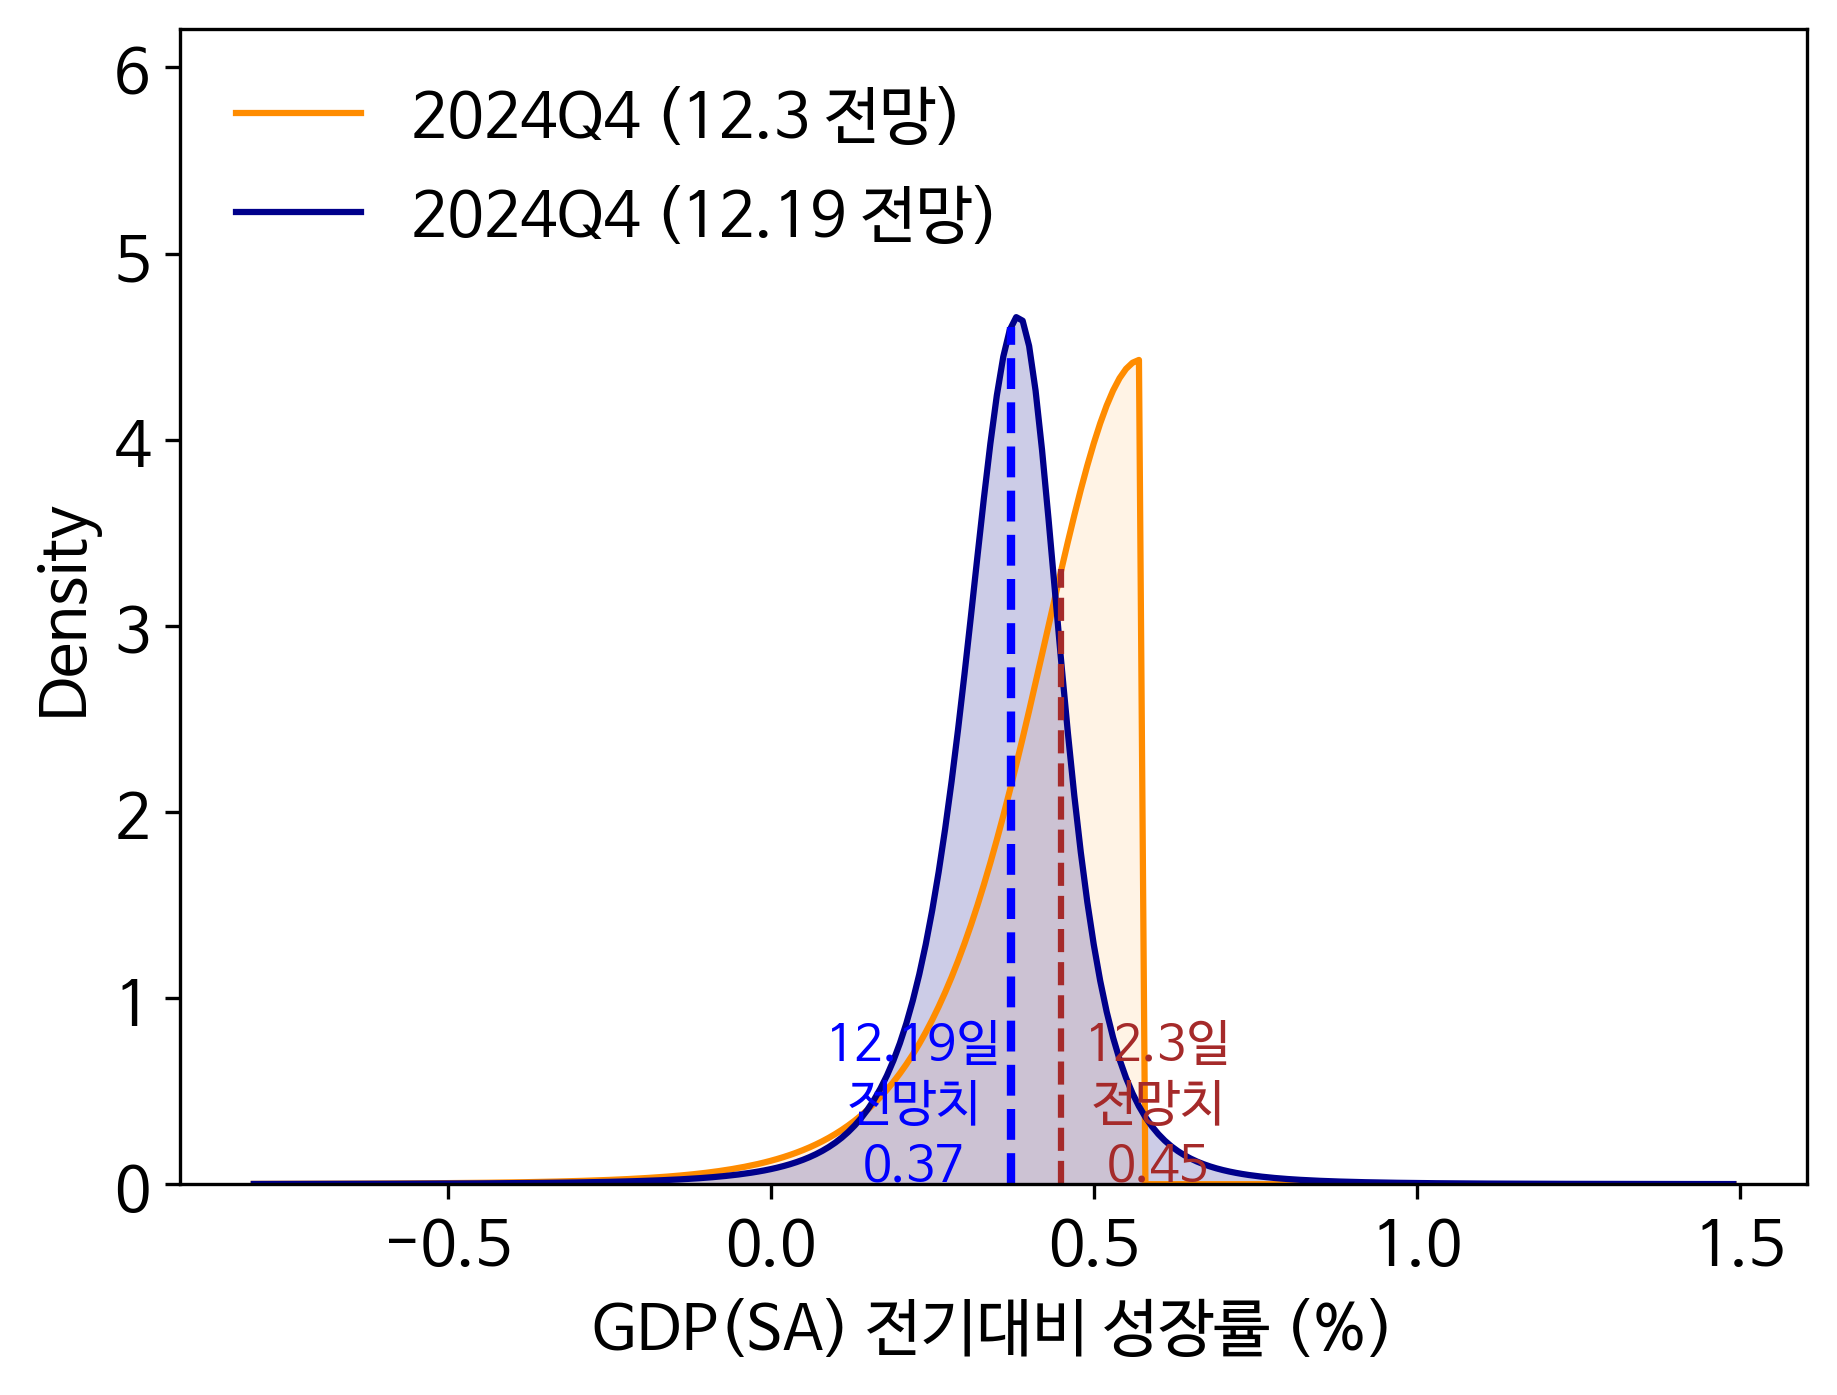

In [1156]:
plt.rc('font', size=15)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기
# plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
# plt.rc('legend', fontsize=20)  # 범례 폰트 크기
# plt.rc('figure', titlesize=50) # figure title 폰트 크기

fig, ax = plt.subplots(figsize=(7,5), dpi=300)

# ax_p = sns.lineplot(x=x_list, y=plotDat(p,x_list,params_hat_prev), color='darkorange', label='2024Q4 ({} 전망)'.format(points_pre.name.split(' ')[0]))
ax_p = sns.lineplot(x=x_list, y=plotDat(p,x_list,params_hat_prev), color='darkorange', label='2024Q4 (12.3 전망)'.format(points_pre.name.split(' ')[0]))
# ax_c = sns.lineplot(x=x_list, y=plotDat(c,x_list), color='darkblue', label='2024Q4 ({} 전망)'.format(points_cur.name.split(' ')[0]))
ax_c = sns.lineplot(x=x_list, y=plotDat(c,x_list), color='darkblue', label='2024Q4 (12.19 전망)'.format(points_cur.name.split(' ')[0]))


kdeline_p = ax.lines[0]
kdeline_c = ax.lines[1]

xs_p = kdeline_p.get_xdata()
ys_p = kdeline_p.get_ydata()

xs_c = kdeline_c.get_xdata()
ys_c = kdeline_c.get_ydata()

# mean = np.array(points_cur).mean()

mode_p = qval_['yhat-'][points_pre.name]#np.mean(points_pre)#xs_p[np.argmax(ys_p)]
mode_c = qval_['yhat-'][points_cur.name]#np.mean(points_cur)#xs_c[np.argmax(ys_c)]

height_p = np.interp(mode_p, xs_p, ys_p)
height_c = np.interp(mode_c, xs_c, ys_c)

ax_p.fill_between(xs_p, 0, ys_p, facecolor='darkorange', alpha=0.1)
ax_p.vlines(mode_p, 0, height_p, color='brown', ls='--')
ax_c.fill_between(xs_c, 0, ys_c, facecolor='darkblue', alpha=0.2)
ax_c.vlines(mode_c, 0, height_c, color='blue', ls='--', lw=2)

plt.text(mode_c-0.15,0.03,'12.19일\n전망치\n'+'{:.2f}'.format(np.round(mode_c,2)), color='blue',horizontalalignment='center', weight='bold', fontsize=12)
plt.text(mode_p+0.15,0.03,'12.3일\n전망치\n'+'{:.2f}'.format(np.round(mode_p,2)), color='brown',horizontalalignment='center', weight='bold', fontsize=12)
print('DQS Prev:',mode_p,' DQS Cur:', mode_c)

def BM_annotate(i, neg=1):
    h = np.interp(points_cur[i], xs_c, ys_c)
    plt.scatter(points_cur[i],h, color='k')
    text = BM[c][i]
    if neg>=1:
        plt.text(points_cur[i]+(neg-1)*len(text)/40,h+0.05,text)
    elif neg<1:
        plt.text(points_cur[i]+neg*len(text)/40,h+0.05,text)

# select models you want to print on the dist.
# BM_annotate(i = 1)
# BM_annotate(i = 2, neg=-2.5)
# BM_annotate(i = 5, neg=1)
# BM_annotate(i = 6,neg=-1)
# BM_annotate(i = 7,neg=-2.5)
# BM_annotate(i = 8,neg=-2.5)
# BM_annotate(i = 9, neg=-1)
# BM_annotate(i = 10)
# BM_annotate(i = 11, neg=-2.5)
# BM_annotate(i = 12)


# plot formatting
plt.legend(prop={'size': 15}, frameon=False, loc=2)
plt.xlabel('GDP(SA) 전기대비 성장률 (%)', weight='bold')
plt.ylabel('Density')#, weight='bold')

plt.ylim((0,max(height_p,height_c)+1.6))
# ylocs, ylabels = plt.yticks()
# plt.yticks([0,1,2,3,4],[0,1,2,3,4])
# plt.ylim((0,2.3))

# plt.arrow(-0.02, 0.4, +0.1, 0,
#           head_width = 0.4,
#           head_length = 0.05,
#           width = 0.1,
#           color ='red')

plt.savefig('./fig/now_dens_t__{}__.png'.format(TODAY), bbox_inches='tight', dpi=300)

In [1157]:
qval_

,q,yhat,q-,yhat-,mean,med,lev
7.7 (2/4),50.000000,0.835556,50.000000,0.835556,NaN,NaN,NaN
6.30 (3/4),50.000000,0.736923,50.000000,0.736923,NaN,NaN,NaN
7.7 (3/4),49.414230,0.687891,49.398708,0.687835,0.663846,0.690000,200.0
7.27 (3/4),47.365264,0.481030,47.535818,0.482258,0.566923,0.500000,200.0
8.4 (3/4),50.000000,0.510000,50.000000,0.510000,0.530000,0.510000,200.0
8.30 (3/4),50.000000,0.390000,50.000000,0.390000,0.388182,0.390000,200.0
9.15 (3/4),50.000000,0.335000,50.000000,0.335000,0.338000,0.335000,200.0
10.4 (3/4),50.000000,0.580000,50.000000,0.580000,0.532727,0.580000,200.0
10.12 (3/4),50.000000,0.610000,50.000000,0.610000,0.568182,0.610000,200.0
7.27 (4/4),50.000000,0.670000,50.000000,0.670000,0.613846,0.670000,200.0


### 2-2.  Box plot trend

In [1158]:
# bp = np.empty((max([len(XXR[x]) for x in XXR]),len(XXR)))
# bp[:] = np.nan

# for i,x in enumerate(XXR):
#     l = len(XXR[x])
#     bp[:l,i] = XXR[x]

# bp = pd.DataFrame(bp)
# bp.columns = XXR.keys()

In [1159]:
'''
bp = pd.DataFrame(np.nan, index=range(10000), columns=DAT.index)

for t in tqdm(DAT.index):
    try:
        mu_0 = qval_.loc[t,'yhat-']
    except:
        mu_0 = MXR.loc[t,'mean']
        print(t)

    sigma_0 = MXR.loc[t,'std']
    q10 = DAT.loc[t,'p10']
    q25 = DAT.loc[t,'p25']
    q75 = DAT.loc[t,'p75']
    q90 = DAT.loc[t,'p90']
    nu_0 = params_hat_prev.loc[t,'nu']
    tau_0 = params_hat_prev.loc[t,'tau']

    temp = SST(mu_0, sigma_0, nu_0, tau_0)

    np.random.seed(0)
    bp[t] = temp.r(10000)
'''

"\nbp = pd.DataFrame(np.nan, index=range(10000), columns=DAT.index)\n\nfor t in tqdm(DAT.index):\n    try:\n        mu_0 = qval_.loc[t,'yhat-']\n    except:\n        mu_0 = MXR.loc[t,'mean']\n        print(t)\n\n    sigma_0 = MXR.loc[t,'std']\n    q10 = DAT.loc[t,'p10']\n    q25 = DAT.loc[t,'p25']\n    q75 = DAT.loc[t,'p75']\n    q90 = DAT.loc[t,'p90']\n    nu_0 = params_hat_prev.loc[t,'nu']\n    tau_0 = params_hat_prev.loc[t,'tau']\n\n    temp = SST(mu_0, sigma_0, nu_0, tau_0)\n\n    np.random.seed(0)\n    bp[t] = temp.r(10000)\n"

#### <font color=red> Select quarter index you want to plot

In [1184]:
def resample(t):


    sigma_0 = MXR.loc[t,'std']
    try:
        dqs = qval_.loc[t,'yhat-']
    except:
        dqs = MXR.loc[t,'med']

    q5 = DAT.loc[t,'p5']
    q95 = DAT.loc[t,'p95']
    bounds = [(q5,q95), (0.01,10), (2.0,10)]
    res = minimize(lambda x: sstq2(x,sigma_0, q5, dqs, q95), x0=(dqs, 1,5), bounds=bounds)#, method = 'BFGS')
    mu_0 = res.x[0]
    nu_0 = res.x[1]
    tau_0 = res.x[2]
    print(t, res)

#     if tau_0==2.0:
#         tau_0 += 0.0000001

    return SST(mu_0,sigma_0,nu_0,tau_0).r(10000)

In [1185]:
# tps = [list(XXR.keys())[-18:][x] for x in [-12,-11,-10,-6,-4,-2,-5,-3,-1]] #7
# tps = [list(XXR.keys())[-18:][x] for x in [-8,-6,-4,-2,-7,-5,-3,-1]] #7
# tps = [list(XXR.keys())[-18:][x] for x in [-16,-14,-10,-6,-4,-9,-5,-3,-2,-1]] #7
# tps = [list(XXR.keys())[-18:][x] for x in [-14,-12,-8,-6,-4,-2,-3,-1]] #7
# tps = [list(XXR.keys())[-18:][x] for x in [-11,-9,-7,-5,-3,-2,-1]] #7
tps = [list(XXR.keys())[-18:][x] for x in [-13, -10,-4,-2,-9,-3,-1]] #7
tps

['9.30 (4/4)',
 '24.10.31 (4/4)',
 '24.12.3 (4/4)',
 '24.12.19 (4/4)',
 '24.10.31 (25.1/4)',
 '24.12.3 (25.1/4)',
 '24.12.19 (25.1/4)']

In [1186]:
bp = pd.DataFrame(np.nan, index=range(10000), columns=tps)
for t in tqdm(tps):
    bp[t] = resample(t)

  0%|          | 0/7 [00:00<?, ?it/s]

9.30 (4/4)   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.3329120427429216e-13
        x: [ 4.855e-01  7.154e-01  3.220e+00]
      nit: 18
      jac: [ 1.763e-06  1.853e-07 -2.334e-08]
     nfev: 100
     njev: 25
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
24.10.31 (4/4)   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.3571275625012643e-06
        x: [ 4.727e-01  1.281e-02  4.681e+00]
      nit: 19
      jac: [-2.859e-06 -1.526e-06 -2.031e-07]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
24.12.3 (4/4)   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.181569746617796e-07
        x: [ 4.123e-01  1.000e-02  5.288e+00]
      nit: 17
      jac: [ 2.139e-05  9.429e-07  1.084e-07]
     nfev: 92
     njev: 23
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
24.12.19 (4/4)   messa

In [1187]:
min_list = np.min(bp,axis=0)
max_list = np.max(bp,axis=0)
mean_list = qval_['yhat-'][tps]

In [1188]:
plt.rcParams['text.usetex'] = False

In [1189]:
for t in tps:
    max_list[t] = max(QXR.loc[t,'p95'], qval_.loc[t,'yhat-'])
    min_list[t] = min(QXR.loc[t,'p5'], qval_.loc[t,'yhat-'])
    mean_list[t] = qval_.loc[t,'yhat-'] #MXR['mean'][t]

In [1190]:
bp

Output hidden; open in https://colab.research.google.com to view.

In [1191]:
(qval_.loc[bp.columns,'yhat-'] - bp.median())

,0
9.30 (4/4),-0.000153
24.10.31 (4/4),0.000578
24.12.3 (4/4),-0.000965
24.12.19 (4/4),-0.000925
24.10.31 (25.1/4),0.000342
24.12.3 (25.1/4),-0.000411
24.12.19 (25.1/4),-0.001613


In [1192]:
qval_.loc[bp.columns,'yhat-']

,yhat-
9.30 (4/4),0.515000
24.10.31 (4/4),0.510000
24.12.3 (4/4),0.450000
24.12.19 (4/4),0.372346
24.10.31 (25.1/4),0.523069
24.12.3 (25.1/4),0.470670
24.12.19 (25.1/4),0.410776


In [1193]:
bp.median()

,0
9.30 (4/4),0.515153
24.10.31 (4/4),0.509422
24.12.3 (4/4),0.450965
24.12.19 (4/4),0.373272
24.10.31 (25.1/4),0.522727
24.12.3 (25.1/4),0.471081
24.12.19 (25.1/4),0.412389


In [1194]:
bp = bp + (qval_.loc[bp.columns,'yhat-'] - bp.median())

In [1195]:
bp_with_outliers = copy.deepcopy(bp)

In [1196]:
# t = '7.7 (3/4)'
for t in tps:
    for i,x in enumerate(bp[t]):
        if bp[t][i] < min_list[t]:
            bp[t][i] = min_list[t]
        if bp[t][i] > max_list[t]:
            bp[t][i] = max_list[t]

In [1197]:
temp = list(bp.columns)

In [1198]:
temp = [x.replace(' ','\n') for x in temp]

In [1199]:
temp

['9.30\n(4/4)',
 '24.10.31\n(4/4)',
 '24.12.3\n(4/4)',
 '24.12.19\n(4/4)',
 '24.10.31\n(25.1/4)',
 '24.12.3\n(25.1/4)',
 '24.12.19\n(25.1/4)']

In [1200]:
temp = ['9.30\n(4/4)',
 '10.31\n(4/4)',
 '12.3\n(4/4)',
 '12.19\n(4/4)',
 '10.31\n(25.1/4)',
 '12.3\n(25.1/4)',
 '12.19\n(25.1/4)']

In [1201]:
bp.columns = temp

In [1202]:
# temp_ = bp['6.10\n(2/4)'].dropna()
# np.round((np.percentile(temp_,0),np.percentile(temp_,25),np.percentile(temp_,75),np.percentile(temp_,100)),2)

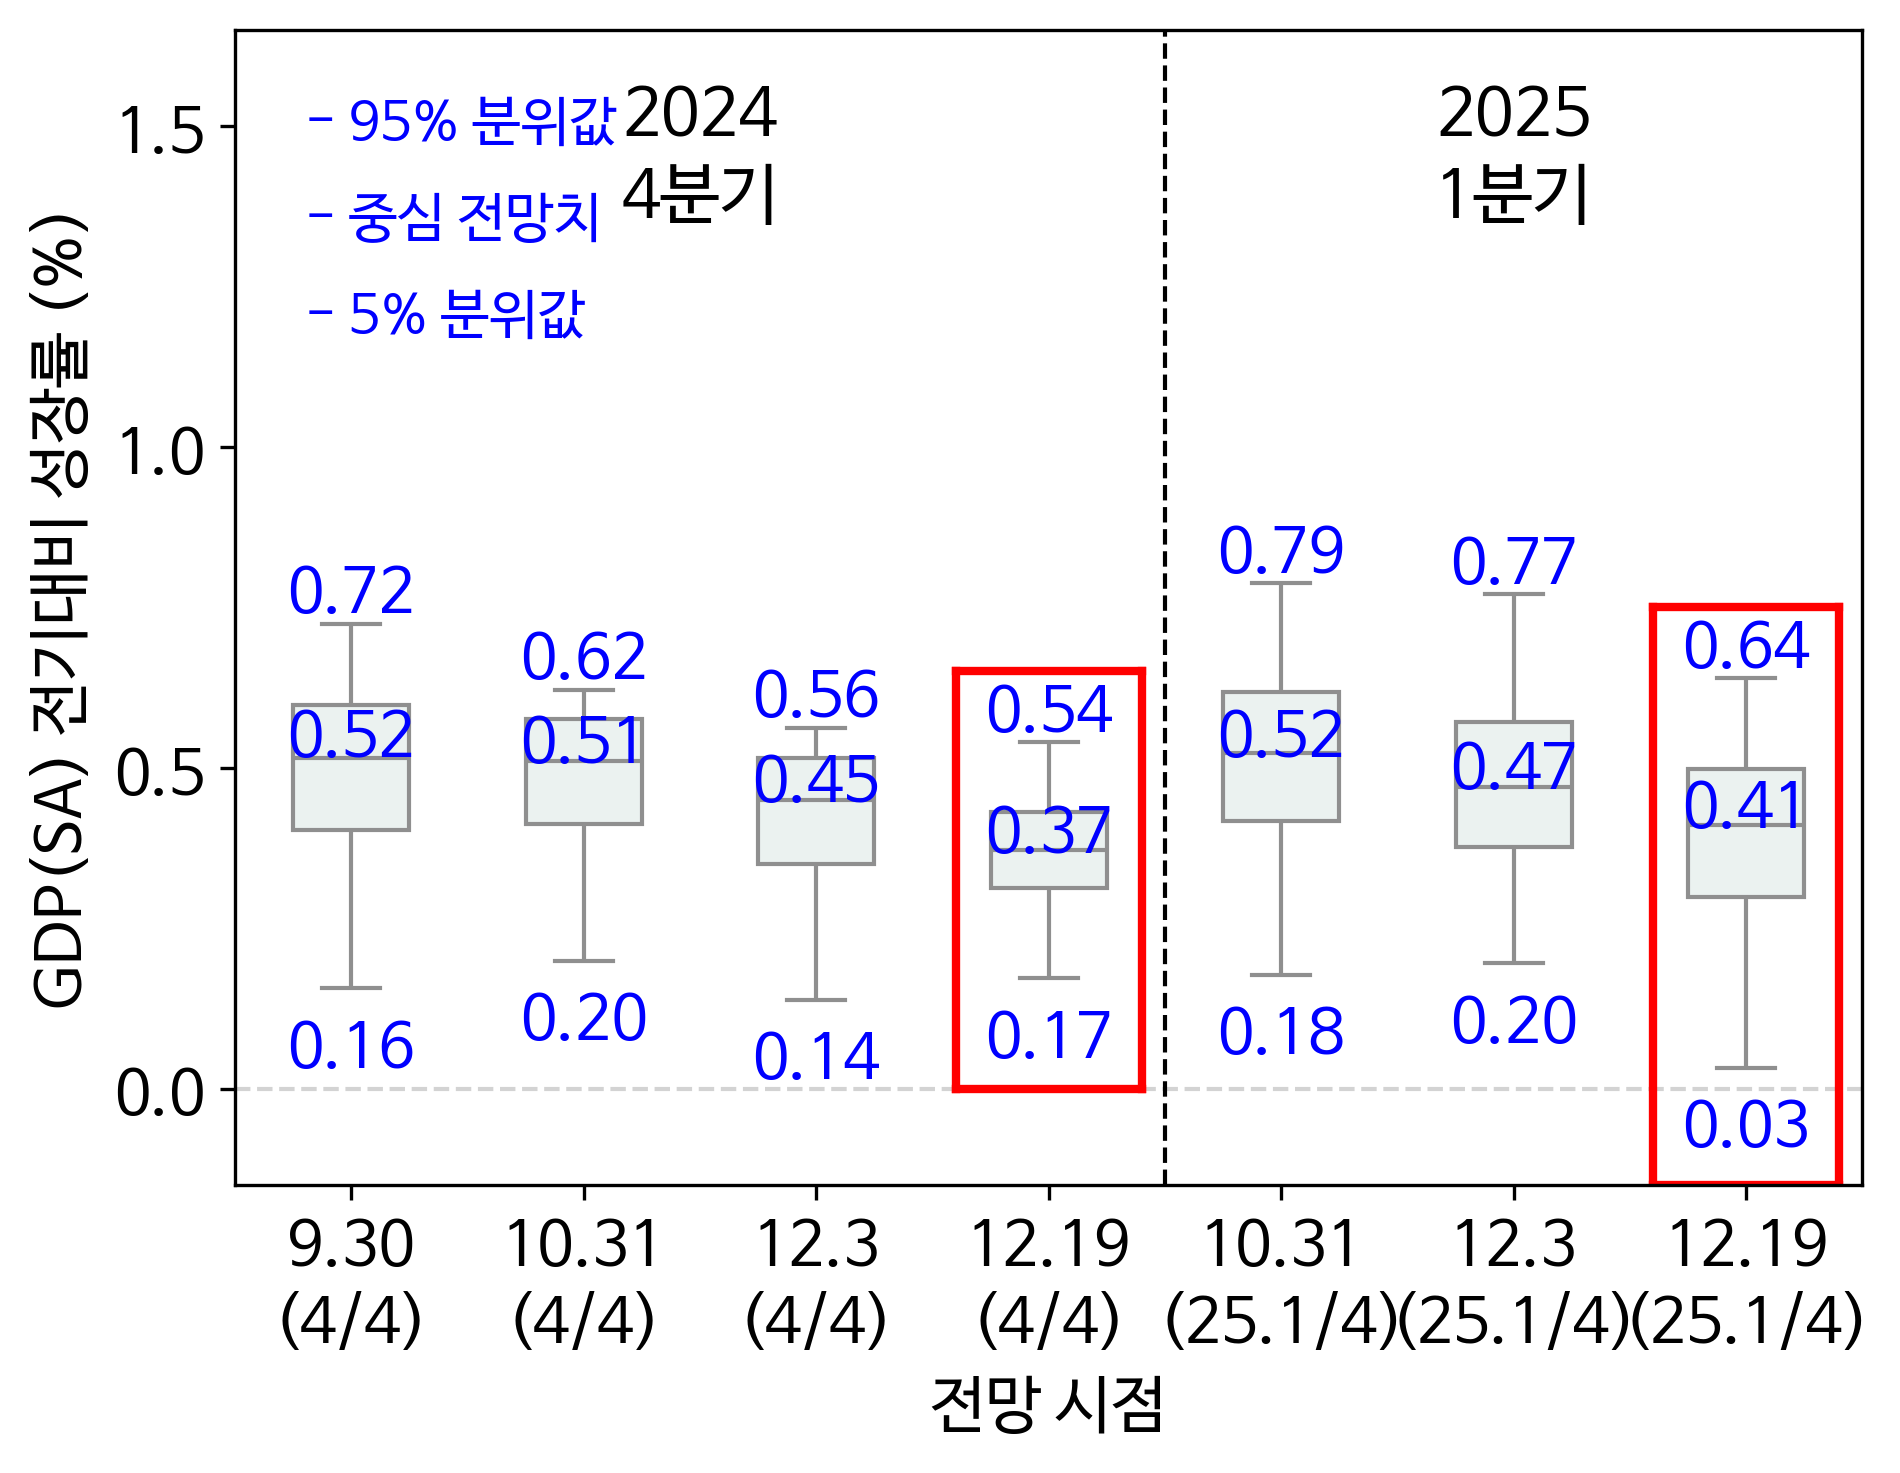

In [1203]:
fs = 15

plt.rc('font', size=15)
fig, ax = plt.subplots(figsize=(7,5), dpi=300)

box_plot = sns.boxplot(
    x = [x[1] for x in bp.stack().index],
    y = bp.stack().loc[[x for x in bp.stack().index]],
    ax = ax,
    whis=(0, 100),
    # width=0.5, palette=sns.color_palette("light:#5A9",n_colors=6), saturation=1,  linewidth=1)
    width=0.5, saturation=1,  linewidth=1, color=sns.color_palette("light:#5A9",n_colors=1)[0])

plt.ylabel('GDP(SA) 전기대비 성장률 (%)', weight='bold')
plt.xlabel('전망 시점', weight='bold')


medians = np.array(np.round(mean_list,2))
for xtick in box_plot.get_xticks():
    t=plt.text(xtick, medians[xtick], "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue', weight='semibold')
#     t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='None'))

medians = np.array(min_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]-0.12, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')

medians = np.array(max_list)
for xtick in box_plot.get_xticks():
    plt.text(xtick, medians[xtick]+0.02, "{:.2f}".format(medians[xtick]),
            horizontalalignment='center',size=fs,color='blue')#,weight='semibold')

adj_hgt = 1.3 # -0.5
loc_x = -0.2 # 0.5
plt.text(loc_x, +0.18+adj_hgt, '- 95% 분위값',
            horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')
plt.text(loc_x, 0.03+adj_hgt, '- 중심 전망치',
            horizontalalignment='left',size=fs-2,color='blue',weight='semibold')
plt.text(loc_x, -0.12+adj_hgt, '- 5% 분위값',
            horizontalalignment='left',size=fs-2,color='blue')#,weight='semibold')


# plt.text(0.5, 1.5, '2024\n2분기',
#             horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold')

plt.text(1.5, 1.45, '2024\n4분기',
            horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold')

# plt.text(6.5, 1.45, '4분기',
plt.text(5.0, 1.45, '2025\n1분기',
            horizontalalignment='center',verticalalignment='center',size=fs+1,color='k',weight='semibold')


plt.axhline(y=0,ls='--',lw=1, color='lightgray')


# plt.axvline(x=1.5,ls='--',lw=1, color='black')
plt.axvline(x=3.5,ls='--',lw=1, color='black')

# pre_end=0.5 + 1.0
# plt.plot([-0.5,pre_end],[-0.2,-0.2],lw=2,color='red')
# plt.text(pre_end-0.5-0.5, -0.3, '(속보:-0.2)',
#             horizontalalignment='center',size=9,color='red',weight='semibold')

# box_plot = sns.boxplot(
#     x = [x[1] for x in bp1.stack().index],
#     y = bp1.stack().loc[[x for x in bp1.stack().index]],
#     ax = ax,
#     width=0.5, palette=sns.color_palette("Reds"), saturation=1,  linewidth=1)


x1 = 2.6; x2 = 3.4
y1 = 0.0; y2 = 0.65
plt.plot([x1,x2],[y1,y1],lw=2,color='red')
plt.plot([x1,x1],[y2,y1],lw=2,color='red')
plt.plot([x2,x2],[y1,y2],lw=2,color='red')
plt.plot([x2,x1],[y2,y2],lw=2,color='red')

x1 = 5.6; x2 = 6.4
y1 = -0.15; y2 = 0.75
plt.plot([x1,x2],[y1,y1],lw=2,color='red')
plt.plot([x1,x1],[y2,y1],lw=2,color='red')
plt.plot([x2,x2],[y1,y2],lw=2,color='red')
plt.plot([x2,x1],[y2,y2],lw=2,color='red')


plt.ylim((-0.15,1.65))
plt.yticks([0.0, 0.5, 1.0, 1.5])
plt.xlim((-0.5, 6.5))


plt.savefig('./fig/now_ts_t_{}_.png'.format(TODAY), bbox_inches='tight', dpi=300)